## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from scripts_step_lr_schedulers import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-192-ratio-2-clean-polish/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", 
                       usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

base_data_path = 'fold_1/'
fold_n = 1
# Unzip files
!tar -xf /kaggle/input/jigsaw-data-split-roberta-192-ratio-2-clean-polish/fold_1.tar.gz

Train samples: 400830


,comment_text,toxic,length,word_count,token_count,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,And you have something alien on your lips Chance. Geez dude give it up. Better yet why don't you ask the Krotch brot...,0.0000,146,28,40,0,train,train,validation,train,train
1,no income tax for anyone that comes and works and leaves. no income tax for retirees that come and work and leave. n...,0.1667,154,30,41,0,train,train,train,train,validation
2,"Rubbish, Brandon. Nothing stopped Comey of the FBI of dumping the phony story about a new investigation in Hillary's...",0.8333,444,75,105,1,train,train,validation,train,train
3,poster I have sent the e-mail. -Garrett,0.0000,39,7,14,0,train,train,validation,train,train
4,== ECB exposure == I responded to a comment of yours here. Cheers.,0.0000,66,13,23,0,train,train,validation,train,train


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,es,0
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",it,0
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",es,1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,tr,0


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 3,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": None,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'MAX_LEN': 192,
 'BATCH_SIZE': 128,
 'EPOCHS': 3,
 'LEARNING_RATE': 1e-05,
 'ES_PATIENCE': None,
 'base_model_path': '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/tf-xlm-roberta-large-tf_model.h5',
 'config_path': '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/xlm-roberta-large-config.json'}

## Learning rate schedule

Learning rate schedule: 0 to 9.84e-06 to 2.29e-06


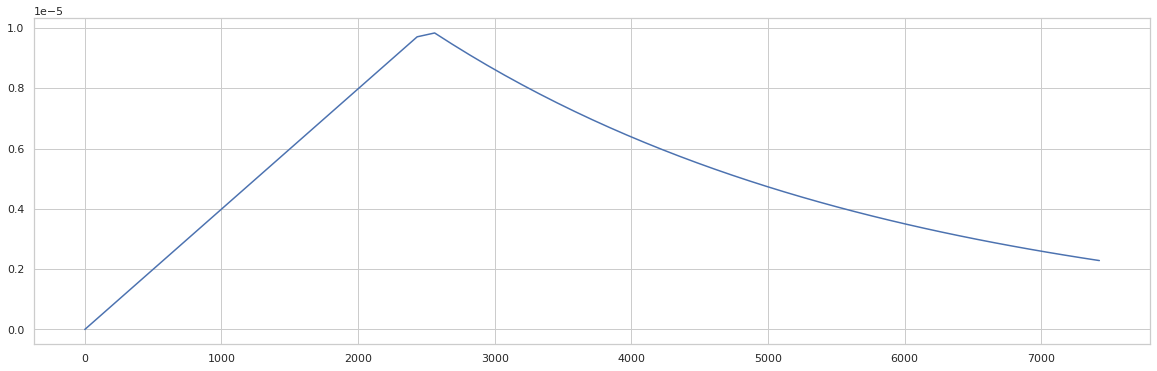

In [5]:
lr_min = 1e-7
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 1
decay = .9997

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps, hold_max_steps, 
                                      lr_start, lr_max, lr_min, decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
# Load data
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train_int.npy').reshape(x_train.shape[1], 1).astype(np.float32)
x_valid = np.load(base_data_path + 'x_valid.npy')
y_valid = np.load(base_data_path + 'y_valid_int.npy').reshape(x_valid.shape[1], 1).astype(np.float32)
x_valid_ml = np.load(database_base_path + 'x_valid.npy')
y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)

#################### ADD TAIL ####################
x_train_tail = np.load(base_data_path + 'x_train_tail.npy')
y_train_tail = np.load(base_data_path + 'y_train_int_tail.npy').reshape(x_train_tail.shape[1], 1).astype(np.float32)
x_train = np.hstack([x_train, x_train_tail])
y_train = np.vstack([y_train, y_train_tail])

step_size = x_train.shape[1] // config['BATCH_SIZE']
valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']
valid_2_step_size = x_valid.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
valid_2_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
train_data_iter = iter(train_dist_ds)
valid_data_iter = iter(valid_dist_ds)
valid_2_data_iter = iter(valid_2_dist_ds)

In [8]:
# Step functions
@tf.function
def train_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(step_size):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_auc.update_state(y, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(valid_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

@tf.function
def valid_2_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_2_auc.update_state(y, probabilities)
        valid_2_loss.update_state(loss)
    for _ in tf.range(valid_2_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

In [9]:
# Train model
with strategy.scope():
    model = model_fn(config['MAX_LEN'])
    
    lr = lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                  warmup_steps=warmup_steps, lr_start=lr_start, 
                                                  lr_max=lr_max, decay=decay)
    
    optimizer = optimizers.Adam(learning_rate=lr)
    loss_fn = losses.binary_crossentropy
    train_auc = metrics.AUC()
    valid_auc = metrics.AUC()
    valid_2_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    valid_2_loss = metrics.Sum()

metrics_dict = {'loss': train_loss, 'auc': train_auc, 
                'val_loss': valid_loss, 'val_auc': valid_auc, 
                'val_2_loss': valid_2_loss, 'val_2_auc': valid_2_auc}

history = custom_fit_2(model, metrics_dict, train_step, valid_step, valid_2_step, train_data_iter, 
                       valid_data_iter, valid_2_data_iter, step_size, valid_step_size, valid_2_step_size, 
                       config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], save_last=False)
# model.save_weights('model.h5')

# Make predictions
# x_train = np.load(base_data_path + 'x_train.npy')
# x_valid = np.load(base_data_path + 'x_valid.npy')
x_valid_ml_eval = np.load(database_base_path + 'x_valid.npy')

# train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
# valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))

# k_fold.loc[k_fold[f'fold_{fold_n}'] == 'train', f'pred_{fold_n}'] = np.round(train_preds)
# k_fold.loc[k_fold[f'fold_{fold_n}'] == 'validation', f'pred_{fold_n}'] = np.round(valid_preds)
valid_df[f'pred_{fold_n}'] = valid_ml_preds

Train for 5010 steps, validate for 62 steps, validate_2 for 626 steps

EPOCH 1/3
time: 1528.5s loss: 0.2409 auc: 0.9599 val_loss: 0.2788 val_auc: 0.9226 val_2_loss: 0.2009 val_2_auc: 0.9761

EPOCH 2/3
time: 1373.5s loss: 0.1595 auc: 0.9822 val_loss: 0.2949 val_auc: 0.9152 val_2_loss: 0.1973 val_2_auc: 0.9766

EPOCH 3/3
time: 1373.5s loss: 0.1410 auc: 0.9859 val_loss: 0.3022 val_auc: 0.9116 val_2_loss: 0.2051 val_2_auc: 0.9763
Training finished


In [10]:
# Fine-tune on validation set
#################### ADD TAIL ####################
x_valid_ml_tail = np.hstack([x_valid_ml, np.load(database_base_path + 'x_valid_tail.npy')])
y_valid_ml_tail = np.vstack([y_valid_ml, y_valid_ml])

valid_step_size_tail = x_valid_ml_tail.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_ml_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_valid_ml_tail, y_valid_ml_tail, config['BATCH_SIZE'], AUTO, seed=SEED))
train_ml_data_iter = iter(train_ml_dist_ds)

In [11]:
# Fine-tune on validation set
history_ml = custom_fit_2(model, metrics_dict, train_step, valid_step, valid_2_step, train_ml_data_iter, 
                          valid_data_iter, valid_2_data_iter, valid_step_size_tail, valid_step_size, valid_2_step_size, 
                          config['BATCH_SIZE'], 2, config['ES_PATIENCE'], save_last=False)

# Join history
for key in history_ml.keys():
    history[key] += history_ml[key]
    
model.save_weights('model.h5')

# Make predictions
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))
valid_df[f'pred_ml_{fold_n}'] = valid_ml_preds

### Delete data dir
shutil.rmtree(base_data_path)

Train for 125 steps, validate for 62 steps, validate_2 for 626 steps

EPOCH 1/2
time: 1373.3s loss: 6.4145 auc: 0.9671 val_loss: 0.1067 val_auc: 0.9874 val_2_loss: 0.2224 val_2_auc: 0.9697

EPOCH 2/2
time: 1373.6s loss: 4.5061 auc: 0.9843 val_loss: 0.0849 val_auc: 0.9915 val_2_loss: 0.2400 val_2_auc: 0.9674
Training finished


## Model loss graph

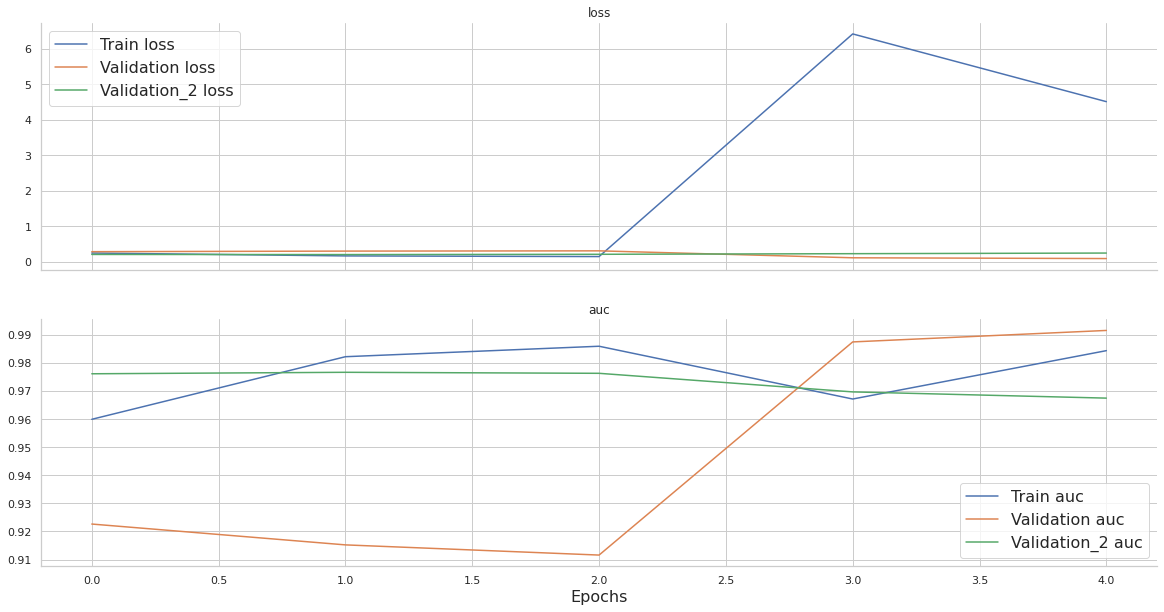

In [12]:
plot_metrics_2(history)

# Model evaluation

In [13]:
# display(evaluate_model_single_fold(k_fold, fold_n, label_col='toxic_int').style.applymap(color_map))

# Confusion matrix

In [14]:
# train_set = k_fold[k_fold[f'fold_{fold_n}'] == 'train']
# validation_set = k_fold[k_fold[f'fold_{fold_n}'] == 'validation'] 
# plot_confusion_matrix(train_set['toxic_int'], train_set[f'pred_{fold_n}'], 
#                       validation_set['toxic_int'], validation_set[f'pred_{fold_n}'])

# Model evaluation by language

In [15]:
display(evaluate_model_single_fold_lang(valid_df, fold_n).style.applymap(color_map))
# ML fine-tunned preds
display(evaluate_model_single_fold_lang(valid_df, fold_n, pred_col='pred_ml').style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.921504,0.921504
es,0.901652,0.901652
it,0.886714,0.886714
tr,0.977852,0.977852


,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.992525,0.992525
es,0.989354,0.989354
it,0.989068,0.989068
tr,0.997593,0.997593


# Visualize predictions

In [16]:
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,And you have something alien on your lips Chance. Geez dude give it up. Better yet why don't you ask the Krotch brot...,0.0000
1,no income tax for anyone that comes and works and leaves. no income tax for retirees that come and work and leave. n...,0.1667
2,"Rubbish, Brandon. Nothing stopped Comey of the FBI of dumping the phony story about a new investigation in Hillary's...",0.8333
3,poster I have sent the e-mail. -Garrett,0.0000
4,== ECB exposure == I responded to a comment of yours here. Cheers.,0.0000
5,"You said, Let's keep abortion safe. Did you mean safe for the mom, or safe for the baby? God forgives women (and men...",0.2000
6,I was responding to Gary (and others) and the letter writer. I believe Christians would be slow to act in this situa...,0.0000
7,Now you disagree with your own comment?,0.0000
8,Amarista definitely needs to go away. If for no other reason than the best poster on this site Northsider will see h...,0.0000
9,"Corspefucking Art I used their offical website as help to gte al information right. Therefore, some sentences were l...",1.0000


Multilingual validation set


,comment_text,toxic,pred_1,pred_ml_1
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.8654,0.6700
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.0001,0.0014
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.9052,0.9115
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.0000,0.0000
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.0001,0.0001
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.0002,0.0003
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.0000,0.0000
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.0010,0.0002
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.0002,0.0001
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.0001,0.0000


# Test set predictions

In [17]:
x_test = np.load(database_base_path + 'x_test.npy')
test_preds = model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO))

In [18]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.0000,63812.0000
mean,31905.5000,0.2349
std,18421.0820,0.3617
min,0.0000,0.0000
25%,15952.7500,0.0001
50%,31905.5000,0.0017
75%,47858.2500,0.4207
max,63811.0000,1.0000


,id,toxic
0,0,0.0000
1,1,0.0006
2,2,0.3402
3,3,0.0002
4,4,0.0001
5,5,0.0050
6,6,0.0000
7,7,0.0001
8,8,0.0563
9,9,0.0620
